In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")[:,0,:]
    else:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [3]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)

L = 10
N = L**2
P = 100000
difftemp = 8
nSteps = 300
dt = 0.02
Ts[10]

2.77

In [4]:
x_recon = np.empty((meas,P,N))
for i,T in enumerate(Ts):
    x_recon[i] = load_data(N,difftemp,P,T,nSteps,dt)
x_true = np.empty((meas,200000,N))
for i,T in enumerate(Ts):
    x_true[i] = load_original_data(L,T,200000)

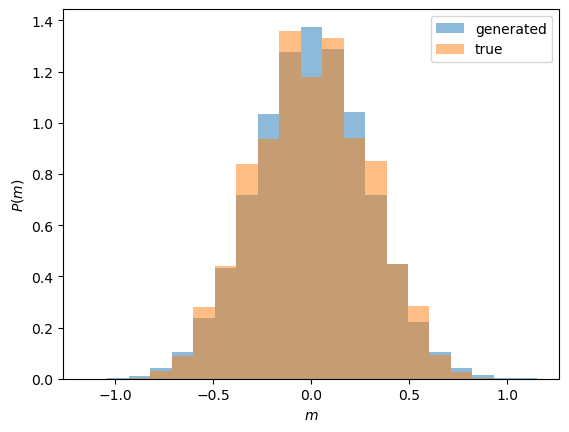

In [5]:
plt.hist(np.mean(x_recon[-1],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "generated")
plt.hist(np.mean(x_true[-1],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()

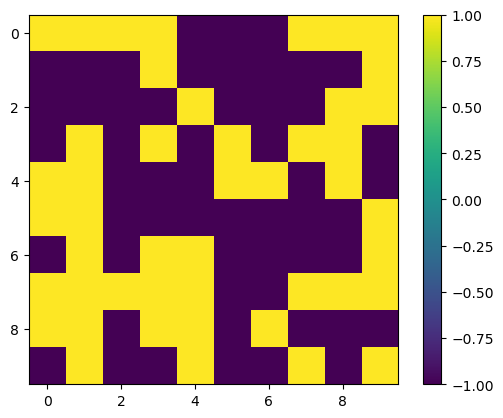

In [147]:
plt.imshow(np.sign(x_recon[0][0]).reshape(L,L))
plt.colorbar()

In [118]:
def get_energy(data):
    en = np.zeros(data.shape[0])
    N = data.shape[1]
    L = int(np.sqrt(N))
    #print(f"N = {N}, L = {L}")
    for i in range(2):
        
        nn = i +1
        if nn >= N:
            nn -= N
        nnsum = data[:,nn]

        nn = i -1
        if nn <0:
            nn += N
        nnsum += data[:,nn]

        nn = i +L
        if nn >= N:
            nn -= N
        nnsum += data[:,nn]

        nn = i -L
        if nn <0:
            nn += N
        nnsum += data[:,nn]
        #print(nnsum)
        en -= data[:,i]*nnsum
        
    return en/(2*N)

In [150]:
cap_true = np.zeros(len(Ts))
cap_recon = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    en = get_energy(x_true[t])
    cap_true[t] = (np.mean(en**2) - np.mean(en)**2)/T**2
    en = get_energy(np.sign(x_recon[t]))
    cap_recon[t] = (np.mean(en**2) - np.mean(en)**2)/T**2

susc_true = np.zeros(len(Ts))
susc_recon = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    magn = np.mean(x_true[t],axis = 1)
    susc_true[t] = (np.mean(magn**2) - np.mean(magn)**2)/T**2
    magn = np.mean(x_recon[t],axis = 1)
    susc_recon[t] = (np.mean(magn**2) - np.mean(magn)**2)/T**2


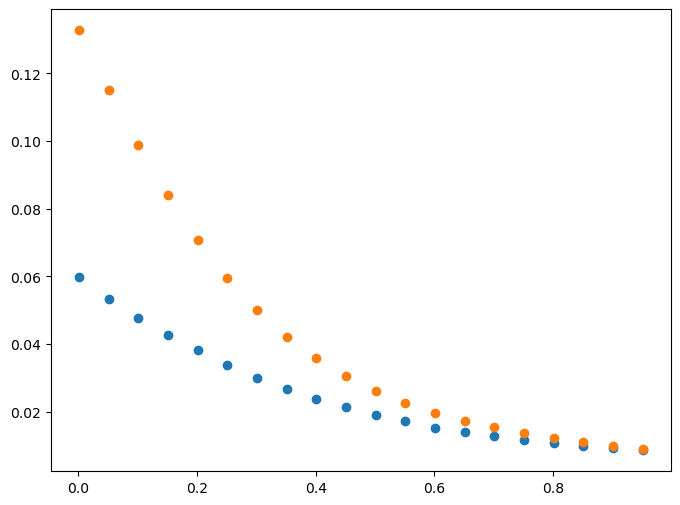

In [153]:
from scipy.optimize import curve_fit as cf
def lin(x,a,b):
    return a*x+b
#popt1, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_recon[5:])
#popt2, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_true[5:])
plt.figure(figsize = (8,6))
plt.scatter((Ts-Tc),susc_recon)
plt.scatter((Ts-Tc),susc_true)
#plt.plot((Ts-Tc)**(7/4), lin((Ts-Tc)**(-7/4),*popt1),color = "C0",linestyle = "--")
#plt.grid("both",linestyle = "--",alpha = 0.2)
#plt.xscale("log")
#plt.yscale("log")

In [17]:
susc_true = np.zeros((len(Ls),len(Ts)))
susc_recon = np.zeros((len(Ls),len(Ts)))
for l,L in enumerate(Ls):
    N = L**2
    for t,T in enumerate(Ts):
        data = load_data(N,difftemp,P,T,nSteps,dt)
        magn = np.mean(np.sign(data),axis = 1)
        susc_recon[l][t] = L**2*(np.mean(magn**2) - np.mean(magn)**2)/T
        data = load_original_data(L,T,200000)
        magn = np.mean(data,axis = 1)
        susc_true[l][t] = L**2*(np.mean(magn**2) - np.mean(magn)**2)/T

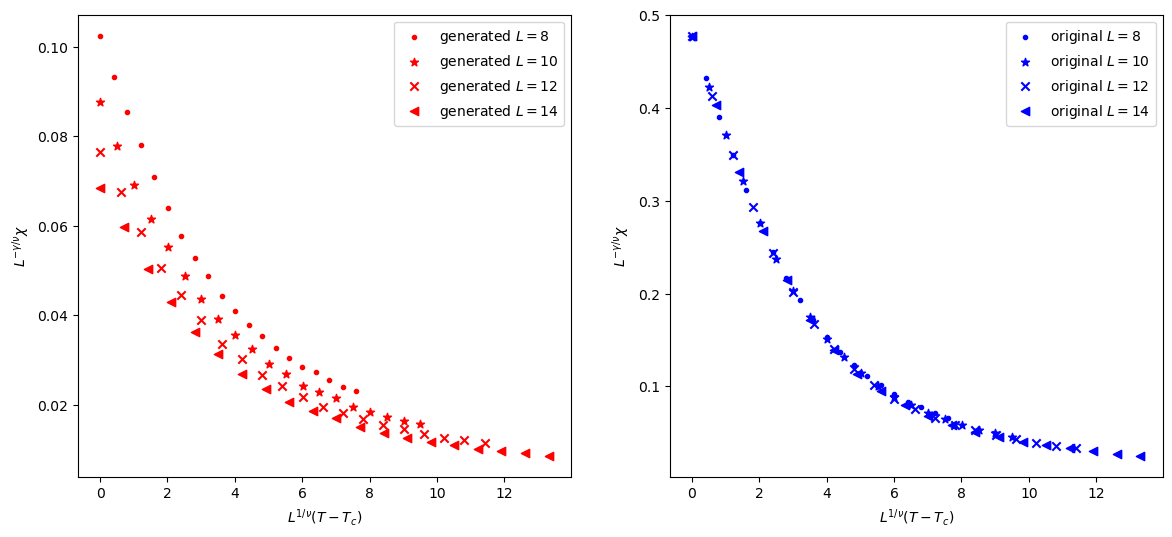

In [24]:
from scipy.optimize import curve_fit as cf
def lin(x,a,b):
    return a*x+b
#popt1, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_recon[5:])
#popt2, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_true[5:])
plt.figure(figsize = (14,6))
mks = [".","*","x","<"]
for l,L in enumerate(Ls):
    plt.subplot(1,2,1)
    plt.scatter(L*(Ts-Tc),susc_recon[l]*L**(-7/4),color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(L*(Ts-Tc),susc_true[l]*L**(-7/4),color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()

#plt.plot((Ts-Tc)**(7/4), lin((Ts-Tc)**(-7/4),*popt1),color = "C0",linestyle = "--")
#plt.grid("both",linestyle = "--",alpha = 0.2)
#plt.xscale("log")
#plt.yscale("log")
